### Solar Radiation Pressure: Various contributions

In this example we will compute the solar radiation pressure on a simple object and analyze the different contributions
- Specular reflection
- Secondary specular reflection
- Diffusion

In [1]:
from pyRTX.classes.Spacecraft import Spacecraft
from pyRTX.classes.RayTracer import RayTracer
from pyRTX.classes.PixelPlane import PixelPlane
from pyRTX.classes.SRP import SolarPressure
from pyRTX.core.analysis_utils import get_spacecraft_area
import trimesh as tm
import numpy as np
import matplotlib.pyplot as plt
import timeit

/Users/gcasciol/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mesh = tm.creation.annulus(0.5,1,height = 0.5)
flux = 1361 # W/m2
mass = 100



Let's define a spacecraft object

In [3]:
sc = Spacecraft( 
            name = 'My Spacecraft',
            base_frame = 'SC Frame', # Name of the spacecraft body-fixed frame
        
            spacecraft_model = { 
       
            
            'Bus': { 
                'file' : mesh, 
                'frame_type': 'UD', # type of frame (can be 'Spice' or 'UD'= User Defined)
                'frame_name': 'SC Bus', # Name of the frame
                'center': [0.0,0.0,0.0], # Origin of the component
                'diffuse': 0.1, # Diffuse reflect. coefficient
                'specular': 0.3, # Specular reflect. coefficient
                
                
            },
            },


                )

#### TODOOOO
####
### Check the area computation!!!
#print(get_spacecraft_area(sc))

In [4]:
RA = 0
DEC = 3*np.pi/180

pixelPlane = PixelPlane(
        spacecraft = 'None',
        mode = 'Fixed',
        distance = 3,
        width = 2,
        height = 2,
        ray_spacing = 0.01,
        lon = RA,
        lat = DEC,
        units = 'm',
)


kernels = ['Embree3', 'Native', 'Embree']

for k in kernels:
    rtx = RayTracer(sc, 
                pixelPlane, 
                kernel = k, 
                bounces = 4, 
                diffusion = False, 
                num_diffuse = 10)



    srp = SolarPressure(sc, rtx, baseflux = None, grouped = False)
    print('Results for kernel = {}'.format(k))
    %timeit -n 5 accel = np.array(srp.compute(0)) * flux/mass
    accel = np.array(srp.compute(0)) * flux/mass
    print('srp_value = {}'.format(np.linalg.norm(accel, axis = 1)))
    print('___________________________________________\n')

Results for kernel = Embree3
23.2 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
srp_value = [5.825e-11 3.003e-13 2.314e-14 8.725e-15]
___________________________________________

Results for kernel = Native
2.51 s ± 234 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
srp_value = [5.856e-11 3.020e-13 2.286e-14 8.428e-15]
___________________________________________

Results for kernel = Embree
38.2 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
srp_value = [5.841e-11 3.019e-13 2.330e-14 8.800e-15]
___________________________________________



Found bounces 4


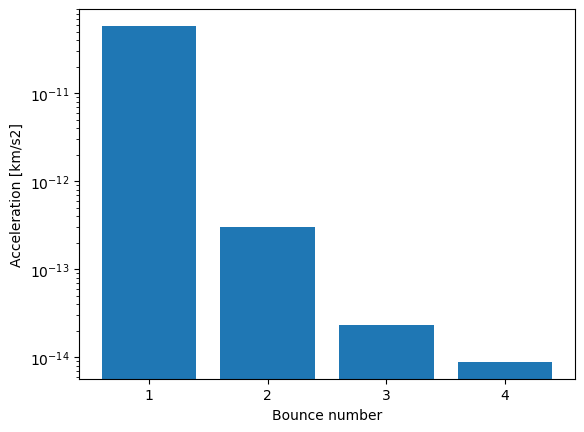

In [5]:
print(f'Found bounces {len(accel)}')

fig, ax = plt.subplots()
ax.bar(np.arange(1, len(accel)+1), np.linalg.norm(accel, axis = 1))
ax.set_yscale('log')
ax.set_ylabel('Acceleration [km/s2]')
ax.set_xlabel('Bounce number')
ax.set_xticks(np.arange(1, len(accel)+1));